# Clasificador **Andrés vs Fondo** con VGG-16

**Objetivo:** Entrenar un clasificador binario con **VGG-16** para distinguir entre:
- **Andres** (rostro del estudiante)
- **Fondo** (otras personas y escenas)

In [1]:
import os, random, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [2]:
BASE = r"D:\Archivos de Usuario\Documents\Artificial-Intelligence\Lab05"
DATASET = os.path.join(BASE, "dataset")

TRAIN_DIR = os.path.join(DATASET, "train")
VAL_DIR   = os.path.join(DATASET, "val")
TEST_DIR  = os.path.join(DATASET, "test")

In [3]:
# Hiperparámetros base
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS_HEAD = 25
EPOCHS_FINE = 15 # fine-tuning
LR_HEAD = 1e-3
LR_FINE = 1e-4

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Carga de datos

Usamos `image_dataset_from_directory` con estructura:

- `dataset/train/Andres`, `dataset/train/Fondo`
- `dataset/val/Andres`, `dataset/val/Fondo`
- `dataset/test/Andres`, `dataset/test/Fondo`

Se aplica `preprocess_input` de VGG-16 y un bloque simple de **data augmentation** en entrenamiento.


In [4]:
def make_ds(dir_path, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        dir_path,
        labels='inferred',
        label_mode='binary', # salida 0/1
        class_names=None,    # usa orden alfabético: ['Andres','Fondo']
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED
    )
    return ds

train_ds = make_ds(TRAIN_DIR, shuffle=True)
val_ds   = make_ds(VAL_DIR, shuffle=False)
test_ds  = make_ds(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
print("Clases:", class_names)  # esperado: ['Andres', 'Fondo']  => Andres=0, Fondo=1

# Cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x,y: (tf.keras.applications.vgg16.preprocess_input(tf.cast(x, tf.float32)), y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.map(  lambda x,y: (tf.keras.applications.vgg16.preprocess_input(tf.cast(x, tf.float32)), y)).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map( lambda x,y: (tf.keras.applications.vgg16.preprocess_input(tf.cast(x, tf.float32)), y)).cache().prefetch(AUTOTUNE)

# Augmentación solo para entrenamiento
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augment")


Found 1516 files belonging to 2 classes.
Found 336 files belonging to 2 classes.
Found 339 files belonging to 2 classes.
Clases: ['Andres', 'Fondo']


## Modelo VGG-16

1. Cargamos **VGG-16** sin la cabeza (``include_top=False``) y con pesos de **ImageNet**.
2. Añadimos una cabeza ligera: **GlobalAveragePooling → Dense(128, ReLU) → Dropout(0.3) → Dense(1, Sigmoid)**.
3. Primera fase: **congelamos VGG-16** y entrenamos solo la cabeza.
4. Segunda fase: **fine-tuning** de las últimas capas de VGG-16.

In [5]:
def build_model(trainable_backbone=False, train_from_block=4):
    base = VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))
    for layer in base.layers:
        layer.trainable = False

    inputs = layers.Input(shape=(224,224,3))
    x = data_augment(inputs)
    x = layers.Lambda(preprocess_input)(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)  # 1 unidad (Andres vs Fondo)

    model = models.Model(inputs, outputs)

    if trainable_backbone:
        # Descongela desde el bloque indicado hacia el final (conv4_x / conv5_x)
        unfreeze = False
        for layer in base.layers:
            if isinstance(layer, layers.Conv2D) and f"block{train_from_block}_" in layer.name:
                unfreeze = True
            if unfreeze:
                layer.trainable = True

    return model

model = build_model(trainable_backbone=False)
model.compile(optimizer=tf.keras.optimizers.Adam(LR_HEAD),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
ckpt_path = os.path.join(BASE, "models", "vgg16_andres_fondo.keras")
os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
]

In [7]:
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8972 - loss: 0.3611
Epoch 1: val_accuracy improved from None to 1.00000, saving model to D:\Archivos de Usuario\Documents\Artificial-Intelligence\Lab05\models\vgg16_andres_fondo.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.9551 - loss: 0.1526 - val_accuracy: 1.0000 - val_loss: 9.1487e-04 - learning_rate: 0.0010
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9945 - loss: 0.0156
Epoch 2: val_accuracy did not improve from 1.00000
48/48 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.9927 - loss: 0.0258 - val_accuracy: 0.9970 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9983 - loss: 0.0096
Epoch 3: val_accuracy did not improve from 1.00000
48/48 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step - accuracy: 0.9974 - loss: 0.0136 - val_accuracy: 1.0000 - val_loss: 2.9994e-04 - learning_rate: 0.0010
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accura

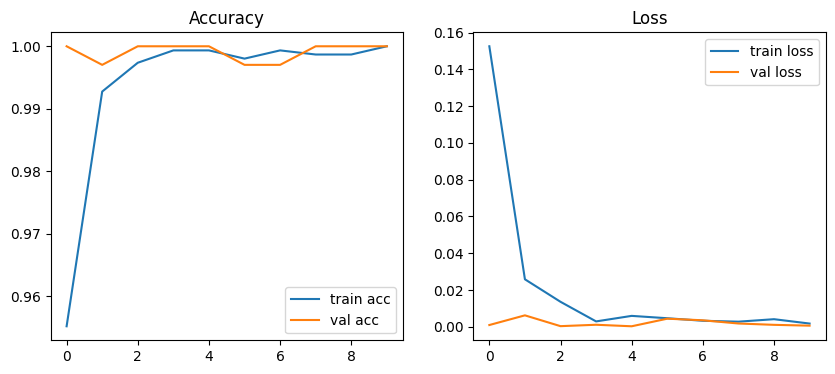

In [8]:
def plot_history(h):
    acc = h.history.get('accuracy', [])
    val_acc = h.history.get('val_accuracy', [])
    loss = h.history.get('loss', [])
    val_loss = h.history.get('val_loss', [])

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(acc, label='train acc')
    plt.plot(val_acc, label='val acc')
    plt.legend(); plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.legend(); plt.title('Loss')
    plt.show()

plot_history(history_head)

In [11]:
# Cargar el mejor checkpoint
best_model = tf.keras.models.load_model(
    ckpt_path,
    custom_objects={'preprocess_input': preprocess_input}
)
print("Mejor modelo cargado:", ckpt_path)


Mejor modelo cargado: D:\Archivos de Usuario\Documents\Artificial-Intelligence\Lab05\models\vgg16_andres_fondo.keras


## Evaluación en `test/`

Calculamos **accuracy**, **matriz de confusión**, **reporte de clasificación** y **AUC-ROC**.

In [16]:
# EVALUACIÓN (convierte p(Fondo) -> p(Andres))
y_true, y_prob = [], []
for xb, yb in test_ds:
    p = best_model.predict(xb, verbose=0).ravel()  # p(Fondo)
    p = 1.0 - p                                    # -> p(Andres)
    y_prob.extend(p)
    y_true.extend(yb.numpy().ravel())

y_true = np.array(y_true).astype(int)  # y_true sigue siendo 0=Andres, 1=Fondo
y_pred = (np.array(y_prob) >= 0.5).astype(int)


## Predicción por ruta y umbral

`predict_image(path, threshold)` devuelve **p(Andres)** y la etiqueta predicha.  


In [17]:
import cv2

# PREDICCIÓN (convierte p(Fondo) -> p(Andres))
def predict_image(path, model, threshold=0.5):
    img = cv2.imread(path); img = cv2.resize(img, IMG_SIZE)
    x = img[..., ::-1].astype(np.float32)
    x = preprocess_input(x)
    x = np.expand_dims(x, 0)
    p = float(model.predict(x, verbose=0)[0][0])  # p(Fondo)
    p = 1.0 - p                                   # -> p(Andres)
    pred_label = "Andres" if p >= threshold else "Fondo"
    return p, pred_label


# Ejemplo (con imágenes en test)
try:
    example_andres = os.path.join(TEST_DIR, "Andres", os.listdir(os.path.join(TEST_DIR,"Andres"))[0])
    example_fondo  = os.path.join(TEST_DIR, "Fondo",  os.listdir(os.path.join(TEST_DIR,"Fondo"))[0])
    for path in [example_andres, example_fondo]:
        prob, lab = predict_image(path, best_model, threshold=0.5)
        print(os.path.basename(path), "->", lab, f"(p_Andres={prob:.3f})")
except Exception as e:
    print("Predicción de ejemplo omitida:", e)


andres_VID_20251022_155106_0002.jpg -> Andres (p_Andres=1.000)
Alisha_Richman_0001.jpg -> Fondo (p_Andres=0.001)


## Guardado del modelo

Se guarda en formato Keras (`.keras`) en `models/`.


In [18]:
final_path_keras = os.path.join(BASE, "models", "vgg16_andres_fondo_final.keras")
best_model.save(final_path_keras)
print("Guardado:", final_path_keras)

# Cargar pasando la función usada en Lambda
loaded = tf.keras.models.load_model(
    final_path_keras,
    custom_objects={'preprocess_input': preprocess_input}
)
print("Modelo cargado OK")


Guardado: D:\Archivos de Usuario\Documents\Artificial-Intelligence\Lab05\models\vgg16_andres_fondo_final.keras
Modelo cargado OK
